In [1]:
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
from nltk.stem import PorterStemmer
import numpy as np
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

2024-02-15 10:53:04.639283: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-15 10:53:04.639425: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-15 10:53:04.799196: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
val_data = pd.read_csv('/kaggle/input/emotion-dataset/validation.csv')
train_data = pd.read_csv('/kaggle/input/emotion-dataset/training.csv')
test_data = pd.read_csv('/kaggle/input/emotion-dataset/test.csv')

In [3]:
half_test_data = test_data.iloc[1000:]
test_data = test_data.iloc[:1000]
val_data = pd.concat([val_data, half_test_data], axis=0)

In [4]:
labels_dict = {0:'sadness', 1:'joy', 2:'love', 3:'anger', 4:'fear', 5:'surprise'}
train_data['label_name'] = train_data['label'].map(labels_dict)
train_data.groupby(["label_name","label"]).size()

label_name  label
anger       3        2159
fear        4        1937
joy         1        5362
love        2        1304
sadness     0        4666
surprise    5         572
dtype: int64

In [5]:
all_list = train_data['text'].tolist() + test_data['text'].tolist() + val_data['text'].tolist()

In [6]:
tokenizer1 = Tokenizer()
tokenizer1.fit_on_texts(all_list)
word_index1 = tokenizer1.word_index
stemmer = PorterStemmer()
stemmed_words = [stemmer.stem(word) for word in word_index1.keys()]
tokenizer2 = Tokenizer()
tokenizer2.fit_on_texts(stemmed_words)
word_index2 = tokenizer2.word_index

In [7]:
def preprocess_data(data):
    new_data = []
    for index, row in data.iterrows():
        test_split = row['text'].split()
        stemmed_words2 = [stemmer.stem(word) for word in test_split]
        token_list= tokenizer2.texts_to_sequences([stemmed_words2])[0]
        new_data.append([token_list,row['label']]) 
    return new_data

In [8]:
new_train_data = preprocess_data(train_data)
new_val_data = preprocess_data(val_data)
train_X = [row[0] for row in new_train_data]
train_y = [row[1] for row in new_train_data]
val_X = [row[0] for row in new_val_data]
val_y = [row[1] for row in new_val_data]
length_of_longest_sentence = len(max(train_X, key=len))

66

In [30]:
for i in range(len(train_X)):
    for j in range(length_of_longest_sentence-len(train_X[i])):
        train_X[i].append(0)
        
for i in range(len(val_X)):
    for j in range(length_of_longest_sentence-len(val_X[i])):
        val_X[i].append(0)

In [31]:
train_X = np.array(train_X)
train_y = np.array(train_y)
val_X = np.array(val_X)
val_y = np.array(val_y)
train_y_one_hot = to_categorical(train_y, num_classes=16000)
val_y_one_hot = to_categorical(val_y, num_classes=16000)

Epoch 1/25
500/500 [==============================] - 92s 176ms/step - loss: 1.8362 - accuracy: 0.3249 - val_loss: 1.6139 - val_accuracy: 0.3540
Epoch 2/25


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


500/500 [==============================] - 87s 174ms/step - loss: 1.5989 - accuracy: 0.3199 - val_loss: 1.5819 - val_accuracy: 0.3540
Epoch 3/25
500/500 [==============================] - 86s 172ms/step - loss: 1.5934 - accuracy: 0.3244 - val_loss: 1.6092 - val_accuracy: 0.3540
Epoch 4/25
500/500 [==============================] - 86s 172ms/step - loss: 1.5898 - accuracy: 0.3182 - val_loss: 1.5750 - val_accuracy: 0.3540
Epoch 5/25
500/500 [==============================] - 86s 173ms/step - loss: 1.5741 - accuracy: 0.3441 - val_loss: 1.5831 - val_accuracy: 0.3547
Epoch 6/25
500/500 [==============================] - 86s 173ms/step - loss: 1.4182 - accuracy: 0.4524 - val_loss: 1.0996 - val_accuracy: 0.5847
Epoch 7/25
500/500 [==============================] - 86s 172ms/step - loss: 0.8408 - accuracy: 0.6685 - val_loss: 0.6116 - val_accuracy: 0.8007
Epoch 8/25
500/500 [==============================] - 86s 172ms/step - loss: 0.3972 - accuracy: 0.8697 - val_loss: 0.4013 - val_accuracy: 0.8

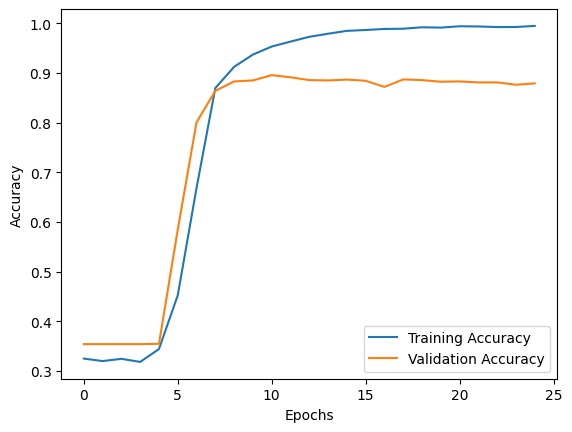

In [36]:
model = Sequential()
model.add(Embedding(16000, 100, input_length=66))
model.add(Bidirectional(LSTM(150)))
model.add(Dense(16000, activation='softmax'))
adam = Adam(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)
history = model.fit(train_X, train_y_one_hot, epochs=25, verbose=1,validation_data=(val_X,val_y_one_hot),callbacks=[ model_checkpoint])

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [39]:
best_model = load_model('best_model.h5')
best_model.save('/kaggle/working/sentiment.h5')

In [41]:
test_loss, test_acc = best_model.evaluate(val_X, val_y_one_hot)
print(f'Test accuracy: {test_acc}')

94/94 [==============================] - 5s 45ms/step - loss: 0.3368 - accuracy: 0.8850
Test accuracy: 0.8849999904632568
